<a href="https://colab.research.google.com/github/jjasira/Neural_network/blob/main/GANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

(128, 28, 28, 1)


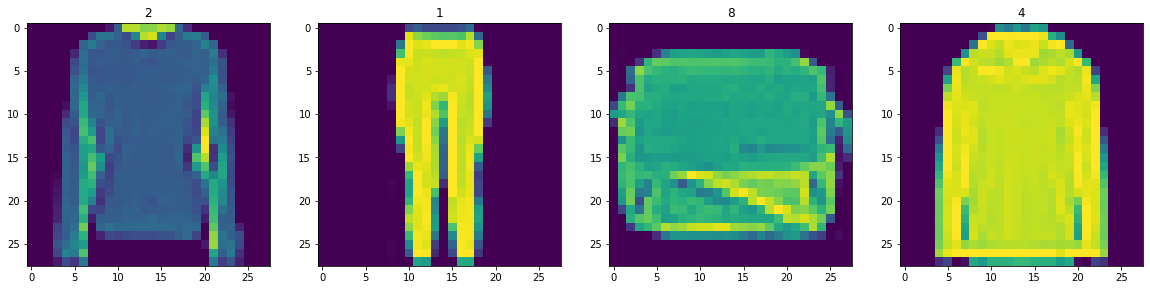

In [6]:
import tensorflow as tf
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D


gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
ds = tfds.load('fashion_mnist', split='train')

dataiterator = ds.as_numpy_iterator()
# dataiterator.next()
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx in range(4):
    batch = dataiterator.next()
    ax[idx].imshow(np.squeeze(batch["image"]))
    ax[idx].title.set_text(batch['label'])


def scale_images(data):
    image = data['image']
    return image / 255


ds = tfds.load('fashion_mnist', split='train')
ds = ds.map(scale_images)
ds = ds.cache()
ds = ds.shuffle(60000)
ds = ds.batch(128)
ds = ds.prefetch(64)

print(ds.as_numpy_iterator().next().shape)

In [20]:
def build_generator():
    model = Sequential()
    model.add(Dense(7*7*128, input_dim=128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7, 7, 128)))

    # Upsampling block 1
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))

    # Upsampling block 2
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))

    # Convolutional block 1
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))

    # Convolutional block 2
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))

    # Conv Layer to get to one channel
    model.add(Conv2D(1, 4, padding='same', activation='sigmoid'))

    return model


generator = build_generator()

img = generator.predict(np.random.randn(4, 128, 1))

1/1 [==============================] - 0s 217ms/step


In [11]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              809088    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                        

In [13]:
img.shape

(4, 28, 28, 1)

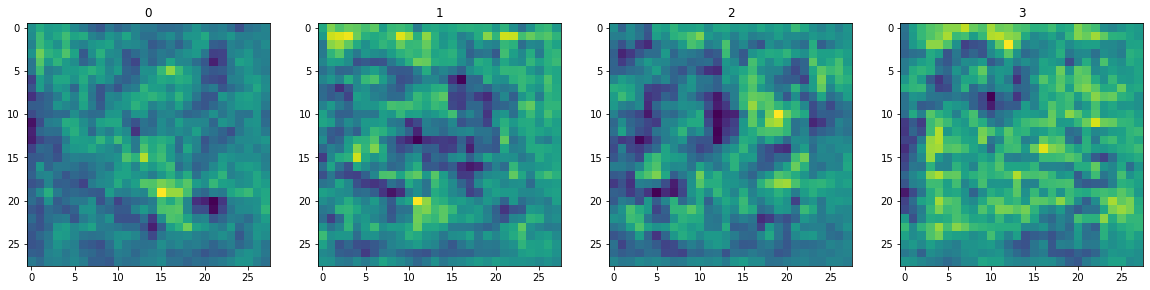

In [21]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))


for idx, img  in enumerate(img):
    
    ax[idx].imshow(np.squeeze(img))
    ax[idx].title.set_text(idx)